In [5]:
!mkdir -p figures
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})

In [5]:
def subG_css(trSigma, lambdamax, n, r):
    """
    Width of sub-Gaussian CSS. See Theorem 1
    """

    beta = np.sqrt(2*trSigma*r / lambdamax)
    lambda_num = beta + 2*r

    lambda_sum = 0
    lambda2_sum = 0

    widths = []
    for t in range(1, n):
        lambda_denom = (lambdamax + trSigma/beta)*t*np.log(t+10e4)
        lambdat =  np.sqrt(lambda_num / lambda_denom)
        lambda_sum += lambdat
        lambda2_sum += lambdat**2/2

        width_num = lambda2_sum*(lambdamax + trSigma/beta) + beta/2 + r
        width_denom = lambda_sum
        widths.append(width_num / width_denom)

    return widths

def Hsu_n(trSigma, trSigma2, lambdamax, n, r):
    """
    Compute width of Hsu's confidence region for n observations.
    """

    s = trSigma + 2*lambdamax*r + 2*np.sqrt(trSigma2*r)
    return np.sqrt(s/n)


def Hsu_doubling(trSigma, trSigma2, lambdamax, n, r):
    """
    Compute width of Hsu's confidence region using
    Duchi and Haque doubling trick.
    """

    widths = []
    for t in range(1, n):
        # if t is a power of 2
        if (t & (t-1)) == 0:
            stitch_count = np.log2(t) + 1
            width = Hsu_n(trSigma, trSigma2, lambdamax, #t/2, r + 2*np.log(np.log2(t)) + 1/2)
                          t, r + np.log(stitch_count**2) + np.log(np.pi**2/6))
            widths.append(width)
        else:
            widths.append(widths[-1])

    return widths

def Hsu_union_bound(trSigma, trSigma2, lambdamax, n, r):
    """
    Compute width of Hsu's confidence region using
    naive union bound.
    """

    widths = []
    for t in range(1, n):
        width = Hsu_n(trSigma, trSigma2, lambdamax, t, r + np.log(t*(t+1)))
                      #r + 2*np.log(t) + np.log(np.pi**2/6))
        widths.append(width)

    return widths


def stitched_css(trSigma, lambdamax, n, r):
    """
    Compute width of stitched CSS.
    """
    widths = []

    for t in range(1, n):

        term1 = 1.21 * np.sqrt(trSigma/t)
        term2 = 1.682*np.sqrt(lambdamax*(r + np.log(1.65) + np.log(np.log2(t) + 1)) / t)

        widths.append(term1 + term2)

    return widths


([<matplotlib.axis.YTick at 0x7f7ada2d6df0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

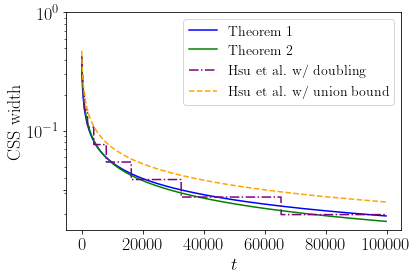

In [6]:
alpha = 0.05
n = 100000

start = 150

TrSigma = 1
TrSigma2 = 1

css = subG_css(TrSigma, 1, n, np.log(1/alpha))
stitched = stitched_css(TrSigma, 1, n, np.log(1/alpha))
stitched_hsu = Hsu_doubling(TrSigma, TrSigma2, 1, n, np.log(1/alpha))
hsu_union = Hsu_union_bound(TrSigma, TrSigma2, 1, n, np.log(1/alpha))


plt.plot(css[start:], label='Theorem 1', c='blue')
plt.plot(stitched[start:], label='Theorem 2', ls='-', c='green')
plt.plot(stitched_hsu[start:], label='Hsu et al. w/ doubling', ls='-.', c='purple')
plt.plot(hsu_union[start:], label='Hsu et al. w/ union bound', ls='--', c='orange')


plt.legend(fontsize=14)
plt.yscale('log')
plt.ylabel('CSS width')
plt.xlabel('$t$')
plt.yticks([10**-1.5, 10**-1, 10**0])

# plt.savefig('figures/subG.png', dpi=300, bbox_inches='tight')



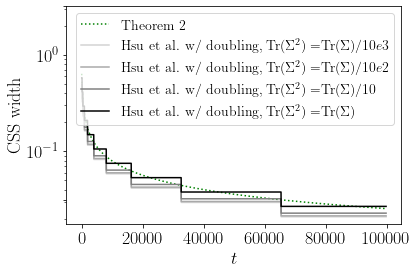

In [7]:
alpha = 0.05
n = 100000
start = 150

stitched = stitched_css(10, 1, n, np.log(1/alpha))

stitched_Hsu_p1 = Hsu_doubling(10, 0.01, 1, n, np.log(1/alpha))
stitched_hsu_1 = Hsu_doubling(10, 0.1, 1, n, np.log(1/alpha))
stitched_hsu_5 = Hsu_doubling(10, 1, 1, n, np.log(1/alpha))
stitched_hsu_10 = Hsu_doubling(10, 10, 1, n, np.log(1/alpha))


plt.plot(stitched[start:], label='Theorem 2', ls=':', c='green')
plt.plot(stitched_Hsu_p1[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/10e3$', ls='-', c='lightgray')
plt.plot(stitched_hsu_1[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/10e2$', ls='-', c='darkgray')
plt.plot(stitched_hsu_5[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/10$', ls='-', c='gray')
plt.plot(stitched_hsu_10[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)$', ls='-', c='black')


plt.yscale('log')
plt.legend(fontsize=14)
plt.ylabel('CSS width')
plt.xlabel('$t$')
plt.yticks([10**-1.5, 10**-1, 10**0, 10**0.5])

plt.savefig('figures/subG_doubling.png', dpi=300, bbox_inches='tight')

